### ⏩Installation of required packages

In [1]:
# For implementing the BorutaShap feature selection algorithm
!pip install BorutaShap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.2 MB/s 


### ⏩ Importing the necessary modules

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from BorutaShap import BorutaShap
from scipy import stats

### ⏩Configuring Kaggle with Google Colab

In [3]:
from google.colab import files # import the files from colab
files.upload() # upload your kaggle.json file form your PC

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sabarinathms","key":"b7df2939a6df5bd4504dd99988b24cdc"}'}

Configuring the Kaggle File

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] ='/content'

### ⏩ Downloading Database
> The database used for this project is the European Soccer Database by Hugo Mathien from Kaggle

> The database has the details of players, teams, matches, etc from 2009 to 2016

> [Clink on the link to get to the database](https://www.kaggle.com/datasets/hugomathien/soccer)








In [8]:
!kaggle datasets download -d hugomathien/soccer

 89% 29.0M/32.7M [00:00<00:00, 135MB/s] 
100% 32.7M/32.7M [00:00<00:00, 132MB/s]


In [9]:
!unzip \*.zip && rm *.zip

Archive:  soccer.zip
  inflating: database.sqlite         


In [10]:
path = '/content/database.sqlite'

In [11]:
connection = sqlite3.connect(path)

In [12]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(query, connection)

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


Only the player and player_attributes table is needed, so we convert them into pandas dataframe

In [13]:
query = "SELECT * FROM Player;"
data = pd.read_sql(query, connection)
data.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [14]:
query = "SELECT * FROM Player_Attributes;"
data = pd.read_sql(query, connection)
data.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


### ⏩ Creating the Dataset for use

In [15]:
# joining the player and the player_attributes tables
query = """SELECT * FROM Player_Attributes a
           INNER JOIN (SELECT player_name, player_api_id AS player_id, birthday FROM Player) b ON a.player_api_id = b.player_id;"""
data = pd.read_sql(query, connection)

In [16]:
data.shape

(183978, 45)

In [17]:
data[['date','birthday']] = data[['date','birthday']].apply(pd.to_datetime)

In [18]:
data.isnull().sum(axis=0)

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [19]:
data.dropna(inplace= True)

In [20]:
#Creating age column by substracting player's birthday from the date of the rating
data['age'] = (data['date'] - data['birthday']).dt.days // 365

In [21]:
# to be used later to analyse the impact of age on rating
player = data.copy()

In [22]:
# getting rid of the duplicate ratings in the dataset
data = data[~data.overall_rating.isnull()].sort_values('date', ascending=False)
data = data.drop_duplicates(subset='player_api_id', keep='first')

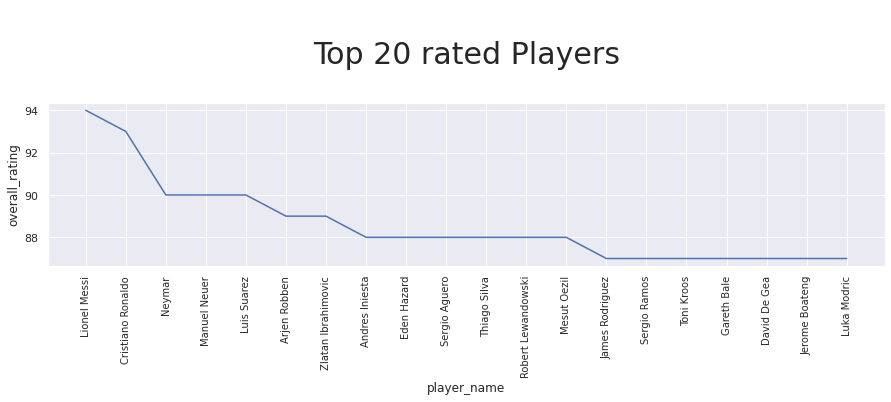

In [23]:
# Top 20 rated players
top_players=data.sort_values(by='overall_rating',ascending=False)
top_twnty=top_players[:20]
sns.set(rc={'figure.figsize':(15,3)})
plt.xticks(fontsize=10,rotation='vertical')
p=sns.lineplot(x="player_name", y="overall_rating", data=top_twnty,palette="summer")
p.axes.set_title("\nTop 20 rated Players\n",fontsize=30);

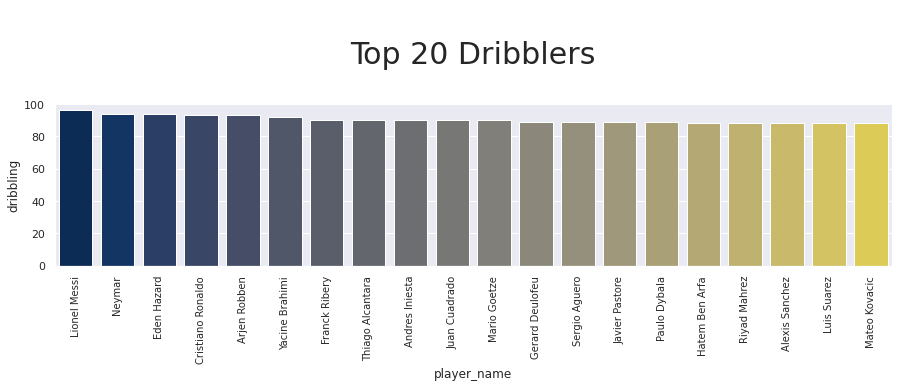

In [24]:
# Top 20 dribblers
top_dribblers=data.sort_values(by='dribbling',ascending=False)
top_twnty=top_dribblers[:20]
sns.set(rc={'figure.figsize':(15,3)})
plt.xticks(fontsize=10,rotation='vertical')
p=sns.barplot(x="player_name", y="dribbling", data=top_twnty,palette="cividis",capsize=2)
p.axes.set_title("\nTop 20 Dribblers\n",fontsize=30);

In [25]:
# Players with best vision
top_vision=data.sort_values(by='vision',ascending=False)
top_twnty=top_vision[:20]
sns.set(rc={'figure.figsize':(3,3)})
fig = px.pie(top_twnty, values="vision", names=top_twnty.player_name, title='Vision analysis')
fig.update_layout(width=1000,height=600,margin=dict(l=50,r=50,b=100,t=100,pad=4))
fig.show()

### ⏩ Analysis of rating with respect to age of player

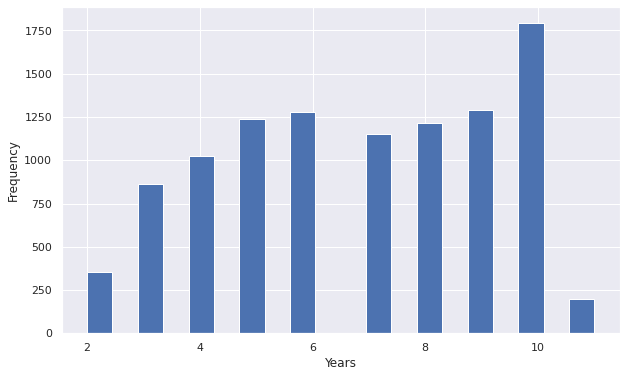

In [26]:
# number of players vs the years for which they were rated
player_years = player.groupby([ 'player_name','player_api_id']).nunique()[['age']]
player_years['age'].plot.hist(figsize=(10,6), bins = 20).set_xlabel("Years");

Text(0, 0.5, 'Rating')

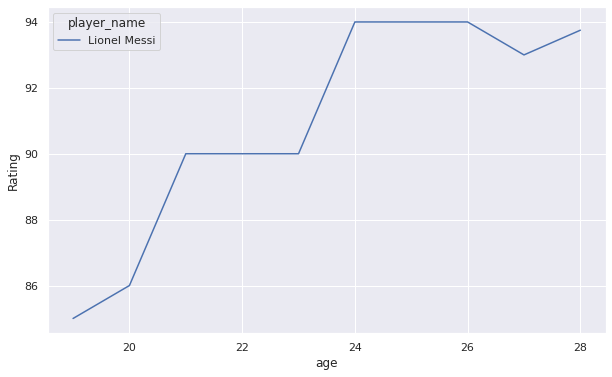

In [27]:
player[player['player_name'].isin(['Lionel Messi'])].groupby(['age','player_name']).mean().reset_index().pivot(index='age', columns='player_name', values='overall_rating').plot(figsize=(10,6)).set_ylabel("Rating")

In [28]:
# Average player rating per age
average_rating_per_year = player.groupby(['age','player_name','player_api_id']).mean().reset_index()

In [29]:
# Average player rating 
average_rating = player.drop(columns = 'age').groupby(['player_api_id']).mean().reset_index()

In [30]:
# % change in rating in every age vs the player's average rating
arpy = average_rating_per_year.merge(average_rating,suffixes=('_yearly', ''), right_on = 'player_api_id', left_on = 'player_api_id' )

for i in list(average_rating.columns)[1:]: 
    arpy[i + '_change%'] = (100*(arpy[i + '_yearly'] - arpy[i])/arpy[i])

In [31]:
# change in the percentage of overall rating per year
arpy[arpy['player_name'].isin(['Lionel Messi'])].pivot(index='age', columns='player_name', values='overall_rating_change%')

player_name,Lionel Messi
age,
19,-7.801418
20,-6.716729
21,-2.377972
22,-2.377972
23,-2.377972
24,1.960784
25,1.960784
26,1.960784
27,0.876095


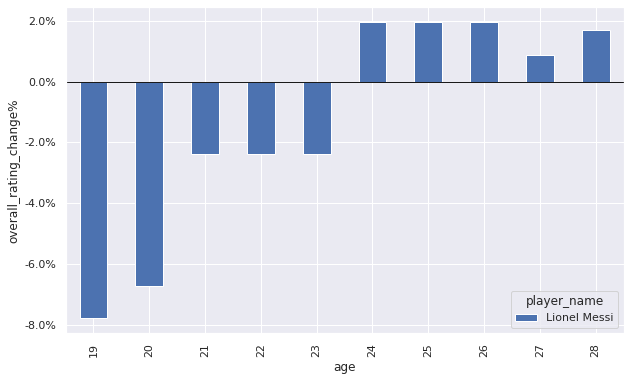

In [32]:

plot = arpy[arpy['player_name'].isin(['Lionel Messi'])].pivot(index='age', columns='player_name', values='overall_rating_change%').plot.bar(figsize=(10,6))
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plot.set_ylabel("overall_rating_change%")
plot.axhline(y=0,linewidth=1, color='k')
plt.legend(title='player_name', loc='lower right')

### ⏩ Similar player scouting

In [33]:
# creating dictionary to store the players as vectors
dic = {}
for name in data["player_name"]:
	row = data[data["player_name"]==name].iloc[[0]]
	name = row.iloc[0]["player_name"]
	overall_rating = row.iloc[0]["overall_rating"]
	potential= row.iloc[0]["potential"]
	crossing= row.iloc[0]["crossing"]
	finishing= row.iloc[0]["finishing"]
	heading_accuracy= row.iloc[0]["heading_accuracy"]
	short_passing= row.iloc[0]["short_passing"]
	volleys= row.iloc[0]["volleys"]
	dribbling= row.iloc[0]["dribbling"]
	curve= row.iloc[0]["curve"]
	free_kick_accuracy= row.iloc[0]["free_kick_accuracy"]
	long_passing= row.iloc[0]["long_passing"]
	ball_control= row.iloc[0]["ball_control"]
	acceleration= row.iloc[0]["acceleration"]
	sprint_speed= row.iloc[0]["sprint_speed"]
	agility= row.iloc[0]["agility"]
	reactions= row.iloc[0]["reactions"]
	balance= row.iloc[0]["balance"]
	shot_power= row.iloc[0]["shot_power"]
	jumping= row.iloc[0]["jumping"]
	stamina= row.iloc[0]["stamina"]
	strength= row.iloc[0]["strength"]
	long_shots= row.iloc[0]["long_shots"]
	aggression= row.iloc[0]["aggression"]
	interceptions= row.iloc[0]["interceptions"]
	positioning= row.iloc[0]["positioning"]
	vision= row.iloc[0]["vision"]
	penalties=row.iloc[0]["penalties"]
	marking= row.iloc[0]["marking"]
	standing_tackle= row.iloc[0]["standing_tackle"]
	sliding_tackle= row.iloc[0]["sliding_tackle"]
	gk_diving=row.iloc[0]["gk_diving"]
	gk_handling= row.iloc[0]["gk_handling"]
	gk_kicking= row.iloc[0]["gk_kicking"]
	gk_positioning= row.iloc[0]["gk_positioning"]
	gk_reflexes = row.iloc[0]["gk_reflexes"]
	vector = (overall_rating,
              potential, crossing, finishing, heading_accuracy, short_passing, volleys,
              dribbling, curve, free_kick_accuracy, long_passing, ball_control,
              acceleration, sprint_speed, agility, reactions, balance, shot_power,
              jumping, stamina, strength, long_shots, aggression, interceptions,
              positioning, vision, penalties, marking, standing_tackle, sliding_tackle,
              gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes)

	dic[name] = vector
    
print ("Final number of players:", len(dic))

Final number of players: 10226


In [34]:

def manhattan_distance(vector1,vector2):
        return sum(abs(vector1[i]-vector2[i]) for i in range(len(vector1)))

In [35]:
# Method that returns an array containing tuples with similar_player_name and manhattan_distance_value
def man_dist (asked_player):
        vector_player1 = list(dic[asked_player])
        similars = {}
        for player in dic:
                if player!= asked_player:
                        vector_player2 = list(dic[player])
                        distance = manhattan_distance(vector_player1,vector_player2)
                        similars[player]=distance
                else:
                        pass
        similars_names = sorted(similars, key=similars.get, reverse=False)
        result = []
        cont = 0
        for similar in similars_names:
                if cont >2:
                        break
                man_dist = similars[similar]
                result.append((similar,man_dist))
                cont +=1 
        return result

In [36]:
similar_players = man_dist("Lionel Messi")
print ("======================SIMILAR PLAYERS TO LIONEL MESSI======================")
print ("First: ", similar_players[0][0], " Distance: ",similar_players[0][1])
print ("Second: ", similar_players[1][0], " Distance: ",similar_players[1][1])
print ("Third: ", similar_players[2][0], " Distance: ",similar_players[2][1])

======================SIMILAR PLAYERS TO LIONEL MESSI======================
First:  Arjen Robben  Distance:  184.0
Second:  Eden Hazard  Distance:  196.0
Third:  Neymar  Distance:  204.0


### ⏩ Preparing the data for model building

In [37]:
# removing the non numeric columns
cols_to_drop = ['id','player_fifa_api_id','date','birthday','age','preferred_foot',
                'attacking_work_rate','defensive_work_rate']

In [38]:
data = data.drop(cols_to_drop, axis=1)

In [39]:
data.shape

(10410, 38)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10410 entries, 181048 to 23855
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_api_id       10410 non-null  int64  
 1   overall_rating      10410 non-null  float64
 2   potential           10410 non-null  float64
 3   crossing            10410 non-null  float64
 4   finishing           10410 non-null  float64
 5   heading_accuracy    10410 non-null  float64
 6   short_passing       10410 non-null  float64
 7   volleys             10410 non-null  float64
 8   dribbling           10410 non-null  float64
 9   curve               10410 non-null  float64
 10  free_kick_accuracy  10410 non-null  float64
 11  long_passing        10410 non-null  float64
 12  ball_control        10410 non-null  float64
 13  acceleration        10410 non-null  float64
 14  sprint_speed        10410 non-null  float64
 15  agility             10410 non-null  float64
 16 

In [41]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
player_api_id,10410.0,162993.167147,163070.354823,2625.0,36812.5,106289.0,229753.5,750584.0
overall_rating,10410.0,68.158021,6.264183,47.0,64.0,68.0,72.0,94.0
potential,10410.0,71.027089,6.202544,49.0,67.0,71.0,75.0,94.0
crossing,10410.0,54.173007,17.548591,6.0,44.0,58.0,67.0,92.0
finishing,10410.0,48.290970,19.014680,5.0,33.0,51.0,64.0,95.0
heading_accuracy,10410.0,56.823631,16.728228,7.0,50.0,60.0,68.0,95.0
short_passing,10410.0,61.995869,13.774904,10.0,58.0,65.0,71.0,93.0
volleys,10410.0,47.889145,17.993338,5.0,34.0,50.0,62.0,92.0
dribbling,10410.0,58.061383,17.804523,6.0,51.0,63.0,70.0,96.0
curve,10410.0,51.996061,18.299131,6.0,40.0,55.0,66.0,94.0


In [42]:
data.isnull().sum(axis=0)

player_api_id         0
overall_rating        0
potential             0
crossing              0
finishing             0
heading_accuracy      0
short_passing         0
volleys               0
dribbling             0
curve                 0
free_kick_accuracy    0
long_passing          0
ball_control          0
acceleration          0
sprint_speed          0
agility               0
reactions             0
balance               0
shot_power            0
jumping               0
stamina               0
strength              0
long_shots            0
aggression            0
interceptions         0
positioning           0
vision                0
penalties             0
marking               0
standing_tackle       0
sliding_tackle        0
gk_diving             0
gk_handling           0
gk_kicking            0
gk_positioning        0
gk_reflexes           0
player_name           0
player_id             0
dtype: int64

Removing the rows with null values

In [43]:
initial_rows = data.shape[0]
df = data.copy()
# Dropping the null rows if any
player_df = df.dropna()

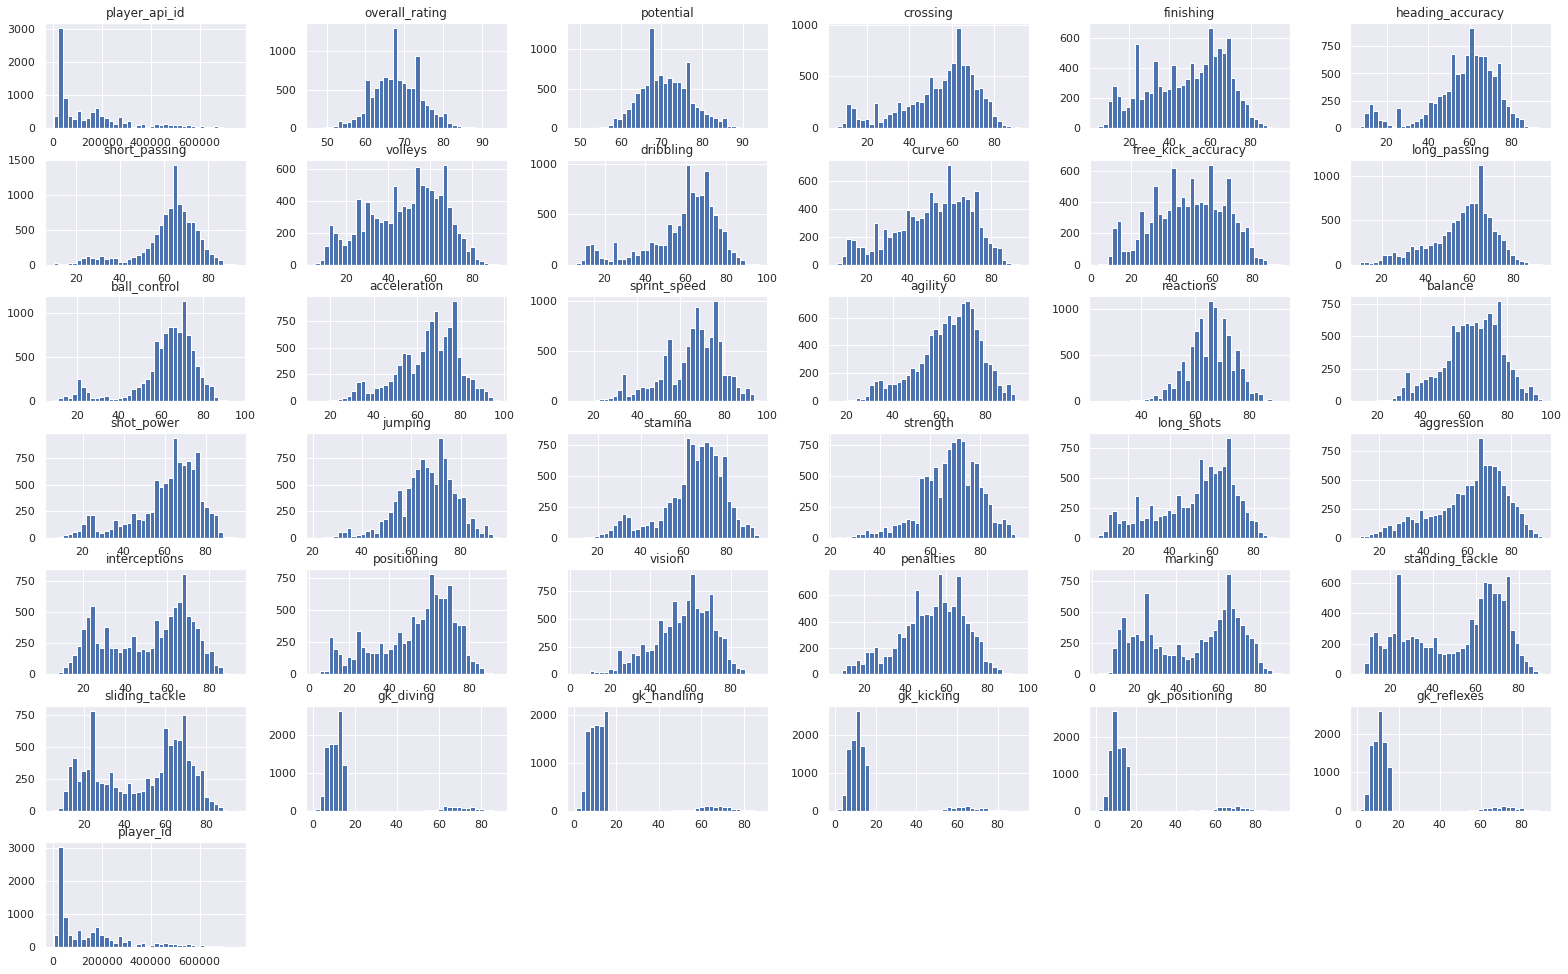

In [44]:
player_df.hist(bins=40, figsize=(27,17))
plt.show()

In [45]:
player_df.head(5)

,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,player_id
181048,512726,63.0,72.0,51.0,66.0,55.0,57.0,60.0,64.0,50.0,...,15.0,16.0,12.0,11.0,12.0,12.0,12.0,7.0,Yanis Mbombo Lokwa,512726
1329,495841,72.0,84.0,49.0,78.0,71.0,63.0,56.0,74.0,45.0,...,20.0,20.0,21.0,6.0,14.0,13.0,8.0,6.0,Adalberto Penaranda,495841
153508,45400,68.0,70.0,33.0,70.0,56.0,63.0,60.0,63.0,55.0,...,23.0,17.0,23.0,13.0,11.0,6.0,9.0,14.0,Ronnie Schwartz,45400
95620,307224,64.0,68.0,44.0,63.0,73.0,49.0,52.0,52.0,42.0,...,22.0,22.0,25.0,12.0,12.0,7.0,11.0,12.0,Kevin Koubemba,307224
18845,317932,66.0,76.0,37.0,27.0,60.0,47.0,32.0,32.0,31.0,...,72.0,73.0,70.0,12.0,11.0,12.0,15.0,7.0,Baptiste Aloe,317932


### ⏩ t-SNE plot of players with rating above 80

In [46]:
# standardizing the features and fitting the data for tsne
cols = ['player_api_id','player_name','overall_rating']
feat_cols = [col for col in player_df.columns if col not in (cols)]

ss = StandardScaler()
temp = ss.fit_transform(player_df[feat_cols])
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(temp)

In [47]:
# only the player ratings above 80 are considered
temp = player_df[cols]
temp['tsne-one'], temp['tsne-two'] = tsne_result[:,0], tsne_result[:,1]
temp = temp[temp.overall_rating >= 80]

In [48]:
_tools = 'box_zoom,pan,save,reset,tap,wheel_zoom'
fig = figure(tools=_tools, title='t-SNE of Players',
             x_axis_label='TSNE 1', y_axis_label='TSNE 2')

source = ColumnDataSource(temp)
hover = HoverTool()
hover.tooltips=[('Player','@player_name'),]
fig.scatter(x='tsne-one', y='tsne-two', source=source, size=8, alpha=0.6,
            line_color='red', fill_color='red')

fig.add_tools(hover)

show(fig)

### ⏩ Train-test split

In [49]:
# 75% train data and 25% test data
train_set, test_set = train_test_split(player_df, test_size=0.25, random_state=42, shuffle=True)

print("Length of training data:", len(train_set))
print("Length of testing data:", len(test_set))
print("Length of total data:", len(player_df))

Length of training data: 7807
Length of testing data: 2603
Length of total data: 10410


### ⏩ Correlation graph showing the impact of all features on the overall rating

In [50]:
cols = ['potential',  'crossing', 'finishing', 'heading_accuracy',
        'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
        'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
        'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
        'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
        'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
        'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
        'gk_reflexes']

In [51]:
train_df = train_set.copy()

correlations = [ train_df['overall_rating'].corr(train_df[f]) for f in cols]

In [52]:
corr_matrix = pd.DataFrame({'attributes': cols, 'correlation': correlations})
corr_matrix

,attributes,correlation
0,potential,0.817933
1,crossing,0.287133
2,finishing,0.266431
3,heading_accuracy,0.220257
4,short_passing,0.406328
5,volleys,0.301406
6,dribbling,0.292616
7,curve,0.320642
8,free_kick_accuracy,0.282834
9,long_passing,0.385933


Plotting the correlation

In [53]:
def plot_corr_dataframe(df, y_label):
    color = 'coral'
    fig = plt.gcf()
    fig.set_size_inches(20, 12)
    plt.ylabel(y_label)
    
    ax = corr_matrix.correlation.plot(linewidth=3.3, color=color)
    ax.set_xticks(corr_matrix.index)
    ax.set_xticklabels(corr_matrix.attributes, rotation=75)
    plt.show()

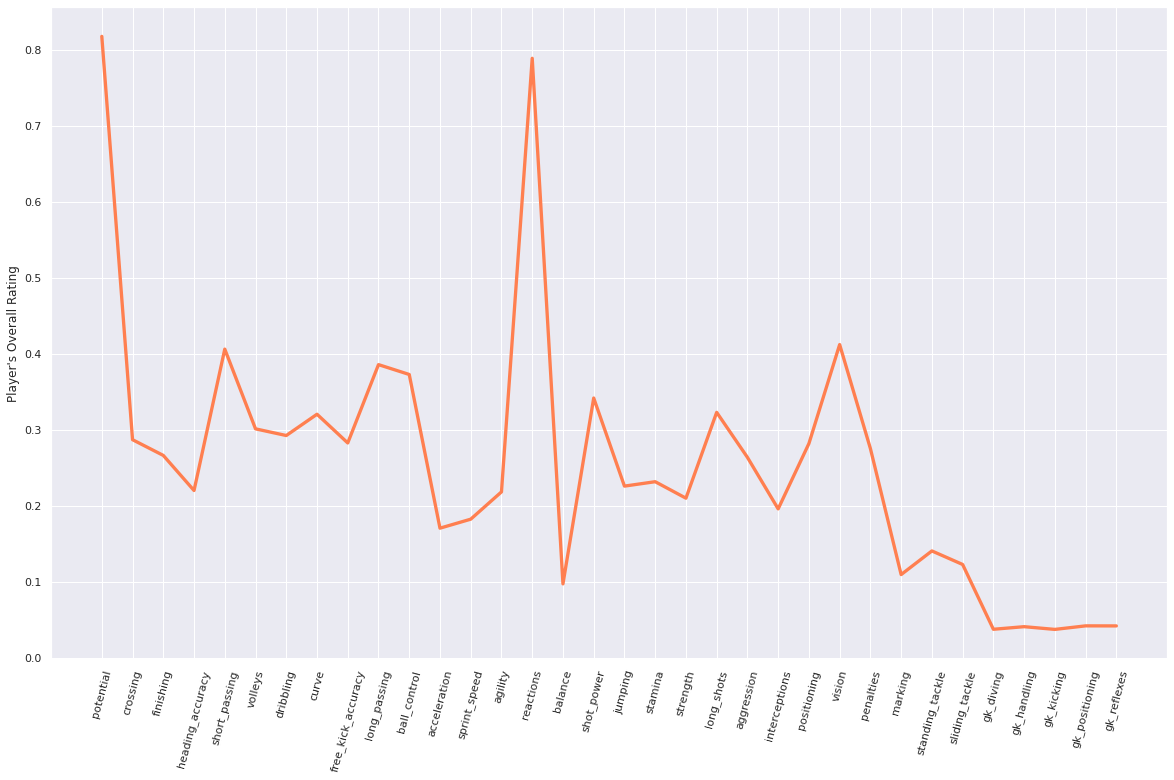

In [54]:
plot_corr_dataframe(corr_matrix, 'Player\'s Overall Rating')

### ⏩ Model Building

In [55]:
y_train = train_set['overall_rating']
X_train = train_set.drop(['overall_rating', 'player_name'], axis=1)
y_test = test_set['overall_rating']
X_test = test_set.drop(['overall_rating', 'player_name'], axis=1)

In [56]:
X_train.shape

(7807, 36)

Boruta Shap for Feature Selection

In [ ]:
Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
Feature_Selector.fit(X=X_train, y=y_train, n_trials=5, sample = False, verbose = True)

  0%|          | 0/5 [00:00<?, ?it/s]

0 attributes confirmed important: []
0 attributes confirmed unimportant: []
37 tentative attributes remains: ['acceleration', 'aggression', 'heading_accuracy', 'gk_kicking', 'gk_positioning', 'long_shots', 'standing_tackle', 'agility', 'penalties', 'vision', 'positioning', 'gk_handling', 'marking', 'balance', 'dribbling', 'age', 'free_kick_accuracy', 'curve', 'jumping', 'ball_control', 'volleys', 'stamina', 'shot_power', 'reactions', 'sprint_speed', 'short_passing', 'player_api_id', 'player_id', 'strength', 'interceptions', 'crossing', 'long_passing', 'sliding_tackle', 'finishing', 'gk_diving', 'potential', 'gk_reflexes']


**Model Selection and execution**

1. Linear Regression

In [57]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

Measuring the performance of Linear Regression

In [58]:
y_predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, y_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.991002322310114

2. Decision Tree

In [59]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

Measuring the performance of Decision Tree

In [60]:
y_predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, y_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

3. Random Forest

In [61]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

Measuring the performance of Random Forest

In [62]:
y_predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, y_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.542790162490985

4. KNN

In [63]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)

KNeighborsRegressor()

Measuring the performance of KNN

In [64]:
y_predictions = knn_reg.predict(X_train)
knn_mse = mean_squared_error(y_train, y_predictions)
knn_rmse = np.sqrt(knn_mse)
knn_rmse

4.7788039115080405

5. SVR

In [65]:
svm_reg = SVR()
svm_reg.fit(X_train, y_train)

SVR()

Measuring the performance of SVR

In [66]:
y_predictions = svm_reg.predict(X_train)
svm_mse = mean_squared_error(y_train, y_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

6.080528188499624

6. XGBoost

In [67]:
xgb_reg = XGBRegressor(objective ='reg:linear', verbosity = 0)
xgb_reg.fit(X_train, y_train)

XGBRegressor(verbosity=0)

Measuring the performance of XGBoost

In [68]:
y_predictions = xgb_reg.predict(X_train)
xgb_mse = mean_squared_error(y_train, y_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

1.350446374125898

In [69]:
print ("======================INITIAL RMSE OF EACH MODEL======================")
print ("Linear Regression: ", lin_rmse)
print ("Decision Tree: ", tree_rmse)
print ("Random Forest: ", forest_rmse)
print ("K Nearest Neighbour: ", knn_rmse)
print ("Support Vector Regression: ", svm_rmse)
print ("XGBoost: ", xgb_rmse)

======================INITIAL RMSE OF EACH MODEL======================
Linear Regression:  1.991002322310114
Decision Tree:  0.0
Random Forest:  0.542790162490985
K Nearest Neighbour:  4.7788039115080405
Support Vector Regression:  6.080528188499624
XGBoost:  1.350446374125898


### ⏩ Validating the results using cross validation method

In [70]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard Deviation:", scores.std())



*   Linear Regression


In [71]:
scores = cross_val_score(lin_reg, X_train, y_train,scoring='neg_mean_squared_error', cv=10)
lin_reg_scores = np.sqrt(-scores)
print ("***Cross Validation score of Linear Regression***")
display_scores(lin_reg_scores)

***Cross Validation score of Linear Regression***
Scores: [1.95328477 2.0600739  1.80156181 1.96127111 1.91881889 2.05584608
 1.94232044 2.05499894 2.0932748  2.14228907]
Mean: 1.9983739797414704
Standard Deviation: 0.09573386560601159


* Decision Tree


In [72]:
scores = cross_val_score(tree_reg, X_train, y_train,scoring='neg_mean_squared_error', cv=10)
tree_reg_scores = np.sqrt(-scores)
print ("***Cross Validation score of Decision Tree***")
display_scores(tree_reg_scores)

***Cross Validation score of Decision Tree***
Scores: [2.35976734 2.35379118 2.33028274 2.331656   2.36518712 2.54108368
 2.20376816 2.35992177 2.4405758  2.394438  ]
Mean: 2.3680471808724244
Standard Deviation: 0.08122965287666141


* Random Forest

In [73]:
scores = cross_val_score(forest_reg, X_train, y_train,scoring='neg_mean_squared_error', cv=10)
forest_reg_scores = np.sqrt(-scores)
print ("***Cross Validation score of Random Forest***")
display_scores(forest_reg_scores)

***Cross Validation score of Random Forest***
Scores: [1.54444098 1.49931252 1.4005586  1.45351149 1.4454994  1.51594394
 1.42330961 1.49853899 1.46718189 1.50512449]
Mean: 1.4753421915535179
Standard Deviation: 0.04261048714153529


* KNN

In [74]:
scores = cross_val_score(knn_reg, X_train, y_train,scoring='neg_mean_squared_error', cv=10)
knn_reg_scores = np.sqrt(-scores)
print ("***Cross Validation score of K Nearest Neighbour***")
display_scores(knn_reg_scores)

***Cross Validation score of K Nearest Neighbour***
Scores: [5.90673567 6.13637587 5.96789962 5.83284005 5.96428122 5.78080182
 6.12758085 5.950195   5.9965845  5.97624786]
Mean: 5.963954245145828
Standard Deviation: 0.10579860577739324


* SVR

In [75]:
scores = cross_val_score(svm_reg, X_train, y_train,scoring='neg_mean_squared_error', cv=10)
svm_reg_scores = np.sqrt(-scores)
print ("***Cross Validation score of Support Vector Regression***")
display_scores(svm_reg_scores)

***Cross Validation score of Support Vector Regression***
Scores: [6.09699101 6.12542104 6.07993876 6.02616492 6.05689668 5.97808146
 6.14638023 6.01953781 6.1449566  6.20075465]
Mean: 6.087512314595972
Standard Deviation: 0.06516889170373678


* XGBoost

In [76]:
scores = cross_val_score(xgb_reg, X_train, y_train,scoring='neg_mean_squared_error', cv=10)
xgb_reg_scores = np.sqrt(-scores)
print ("***Cross Validation score of XGBoost***")
display_scores(xgb_reg_scores)

***Cross Validation score of XGBoost***
Scores: [1.46456006 1.47972703 1.35559111 1.44673765 1.4213527  1.50802155
 1.43973725 1.47305599 1.53856468 1.52723447]
Mean: 1.4654582495455526
Standard Deviation: 0.05124718050357821


### ⏩ Fine tuning the hyperparameters using GridSearchCV

In [77]:
param_grid = {'objective':['reg:linear'],
              'learning_rate': [0.05,0.25,0.50,1],
              'max_depth': [5, 6, 7],
              'min_child_weight': [3,5],
              'n_estimators': [100, 200, 300, 400, 500]}

xgb_reg = XGBRegressor(objective ='reg:linear', verbosity = 0)
grid_search = GridSearchCV(xgb_reg,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True,verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=XGBRegressor(verbosity=0),
             param_grid={'learning_rate': [0.05, 0.25, 0.5, 1],
                         'max_depth': [5, 6, 7], 'min_child_weight': [3, 5],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'objective': ['reg:linear']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [78]:
print("The best parameters are: ", grid_search.best_params_)
print("The best estimator is: ", grid_search.best_estimator_)

The best parameters are:  {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'reg:linear'}
The best estimator is:  XGBRegressor(learning_rate=0.05, max_depth=7, min_child_weight=5,
             n_estimators=500, verbosity=0)


### ⏩ Evaluation of the best model

In [79]:
best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_predictions)
best_rmse = np.sqrt(best_mse)
print("RMSE by the best model on the test dataset: ",best_rmse)

RMSE by the best model on the test dataset:  1.0329150280931896


Calculating the confidence interval

In [80]:
confidence = 0.95
squared_errors = (best_predictions - y_test)**2
conf=np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))
print("We are 95% confident that the rmse values would be between ",conf[0],"and",conf[1])

We are 95% confident that the rmse values would be between  0.9887297449992288 and 1.0752861953337207


Predictions

In [81]:
sample_data = X_test.iloc[:5]
sample_label = y_test.iloc[:5]
print("########## CHECKING HOW GOOD THE PREDICTIONS ARE ##########")
print("Predictions:", best_model.predict(sample_data))
print("True Labels:", list(sample_label))

########## CHECKING HOW GOOD THE PREDICTIONS ARE ##########
Predictions: [75.56884  70.16643  65.05865  66.487465 74.04788 ]
True Labels: [74.0, 70.0, 65.0, 67.0, 75.0]
